In [1]:
#pip install pandas==1.3.0

In [2]:
#pip install plotly==2.0.1

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly.plotly as py

In [2]:
df = pd.read_csv('Labbeled-Dataset.csv', encoding='latin1', engine='python',usecols=['Base_Reviews','My_Labels'])
df = df[pd.notnull(df['My_Labels'])]
print(df.head())
print(df['Base_Reviews'].astype(str).apply(lambda x: len(x.split(' '))).sum())

                                        Base_Reviews   My_Labels
0  Downloaded this on a Kindle Fire 8 HD.  No ind...    decision
1  It's free to download the app, but if you want...    decision
2  I download this app to my Kindle Fire HD. I tr...       issue
3  Dirty trickster! It found my printer and print...       issue
4                Love this for my kindle print needs  supporting
195360


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tahir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df.My_Labels.value_counts()

supporting    5117
attacking     2949
issue         2191
neutral        659
decision       503
Name: My_Labels, dtype: int64

In [5]:
def print_plot(index):
    example = df[df.index == index][['Base_Reviews', 'My_Labels']].values[0]
    if len(example) > 0:
        print(example[0])
        print('My_Labels:', example[1])

In [6]:
print_plot(10)

Easy to install and use.  And FREE.  Had PAID for another printer app when I got new Kindle and their tech support couldn't get it to print so am super pleased with Hammer Print.
My_Labels: supporting


In [7]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

In [8]:
df['Base_Reviews'] = df['Base_Reviews'].str.replace('\d+', '')

C:\Users\tahir\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [9]:
print_plot(10)

easy install use free paid another printer app got new kindle tech support couldnt get print super pleased hammer print
My_Labels: supporting


In [37]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 192

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Base_Reviews'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8151 unique tokens.


In [38]:
X = tokenizer.texts_to_sequences(df['Base_Reviews'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (11419, 250)


In [39]:
Y = pd.get_dummies(df['My_Labels']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (11419, 5)


In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7993, 250) (7993, 5)
(3426, 250) (3426, 5)


In [41]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 192)          9600000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 250, 192)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 100)               117200    
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 9,717,705
Trainable params: 9,717,705
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
88/88 [==============================] - 175s 2s/step - loss: 1.1783 - accuracy: 0.5228 - val_loss: 0.8787 - val_accuracy: 0.6672
Epoch 2/5
88/88 [==============================] - 163s 2s/step - loss: 0.7406 - accuracy: 0.7231 - val_loss: 0.7491 - val_accuracy: 0.7173
Epoch 3/5
88/88 [==============================] - 164s 2s/step - loss: 0.5166 - accuracy: 0.8193 - val_loss: 0.7139 - val_accuracy: 0.7423
Epoch 4/5
88/88 [==============================] - 166s 2s/step - loss: 0.3810 - accuracy: 0.8727 - val_loss: 0.7423 - val_accuracy: 0.7506
Epoch 5/5
88/88 [==============================] - 167s 2s/step - loss: 0.3007 - accuracy: 0.8996 - val_loss: 0.7962 - val_accuracy: 0.7402


In [43]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

108/108 [==============================] - 13s 119ms/step - loss: 0.8572 - accuracy: 0.7358
Test set
  Loss: 0.857
  Accuracy: 0.736


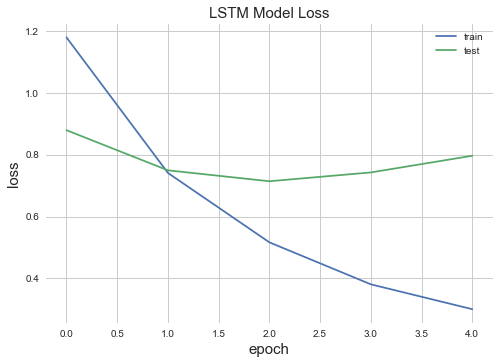

In [61]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image
sns.set_style("whitegrid")
np.random.seed(0)

plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.title('LSTM Model Loss', fontsize=15)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
#plt.show();
plt.savefig("LSTM_loss model.png", dpi=400)

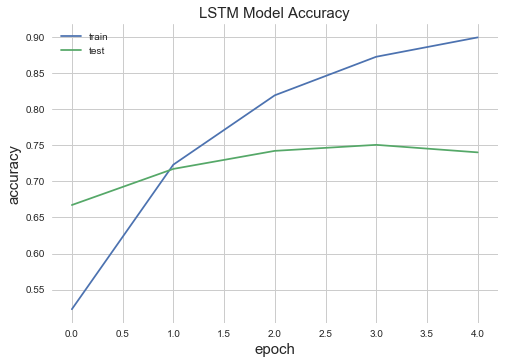

In [62]:
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.title('LSTM Model Accuracy', fontsize=15)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
#plt.show();
plt.savefig("LSTM_Accuracy model.png", dpi=400)

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tahir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install np_utils

In [3]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [4]:
df = pd.read_csv('Labbeled-Dataset_GPT.csv', encoding='latin1', engine='python',usecols=['Base_Reviews','category'])
df = df[pd.notnull(df['category'])]
print(df.head())
print(df['Base_Reviews'].astype(str).apply(lambda x: len(x.split(' '))).sum())

                                        Base_Reviews    category
0  Downloaded this on a Kindle Fire 8 HD.  No ind...    decision
1  It's free to download the app, but if you want...    decision
2  I download this app to my Kindle Fire HD. I tr...       issue
3  Dirty trickster! It found my printer and print...       issue
4                Love this for my kindle print needs  supporting
195360


In [5]:
df.columns

Index(['Base_Reviews', 'category'], dtype='object')

In [6]:
data = df[['Base_Reviews','category']]
data = data.dropna()
data.head(1000)

,Base_Reviews,category
0,Downloaded this on a Kindle Fire 8 HD. No ind...,decision
1,"It's free to download the app, but if you want...",decision
2,I download this app to my Kindle Fire HD. I tr...,issue
3,Dirty trickster! It found my printer and print...,issue
4,Love this for my kindle print needs,supporting
...,...,...
995,Works great,supporting
996,use it all the time no problems,supporting
997,This doesn't work on my Kindle either. Thankf...,issue
998,Very user friendly !!,supporting


In [7]:
data.dtypes

Base_Reviews    object
category        object
dtype: object

In [8]:
data.category.value_counts()

supporting    5117
attacking     2949
issue         2191
neutral        659
decision       503
Name: category, dtype: int64

In [9]:
data.head()

,Base_Reviews,category
0,Downloaded this on a Kindle Fire 8 HD. No ind...,decision
1,"It's free to download the app, but if you want...",decision
2,I download this app to my Kindle Fire HD. I tr...,issue
3,Dirty trickster! It found my printer and print...,issue
4,Love this for my kindle print needs,supporting


In [10]:
def example_complain(index):
    example = data[data.index == index][['Base_Reviews', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print()
        print('Category:', example[1])

In [11]:
example_complain(11)

Worked perfectly right away with my older Brother printer.  It automatically asked to download a generic driver...and it was just what it needed.  Thanks.

Category: supporting


In [12]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Base_Reviews'] = data['Base_Reviews'].apply(clean_text)

In [13]:
example_complain(11)

worked perfectly right away older brother printer automatically asked download generic driverand needed thanks

Category: supporting


In [14]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Base_Reviews'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8503 unique tokens.


In [15]:
X = tokenizer.texts_to_sequences(data['Base_Reviews'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (11419, 250)


In [16]:
Y = pd.get_dummies(data['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (11419, 5)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10277, 250) (10277, 5)
(1142, 250) (1142, 5)


In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
145/145 [==============================] - 80s 535ms/step - loss: 1.1305 - accuracy: 0.5502 - val_loss: 0.8132 - val_accuracy: 0.6858
Epoch 2/5
145/145 [==============================] - 77s 532ms/step - loss: 0.6860 - accuracy: 0.7538 - val_loss: 0.6676 - val_accuracy: 0.7432
Epoch 3/5
145/145 [==============================] - 83s 574ms/step - loss: 0.4965 - accuracy: 0.8277 - val_loss: 0.6489 - val_accuracy: 0.7665
Epoch 4/5
145/145 [==============================] - 88s 606ms/step - loss: 0.3911 - accuracy: 0.8638 - val_loss: 0.6736 - val_accuracy: 0.7675
Epoch 5/5
145/145 [==============================] - 85s 590ms/step - loss: 0.3340 - accuracy: 0.8855 - val_loss: 0.7342 - val_accuracy: 0.7578


In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

36/36 [==============================] - 1s 30ms/step - loss: 0.8331 - accuracy: 0.7452
Test set
  Loss: 0.833
  Accuracy: 0.745


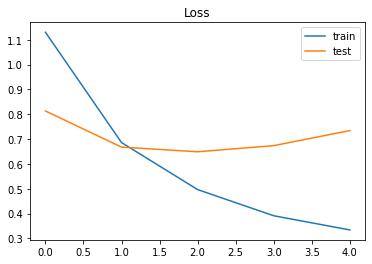

In [21]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

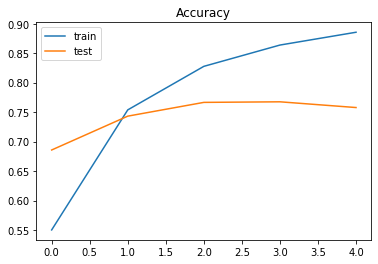

In [22]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [23]:
new_complaint = ['worked perfectly right away older brother printer automatically asked download generic driverand needed thanks']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['decision', 'supporting', 'attacking', 'neutral', 'issue']
print(pred, labels[np.argmax(pred)])

[[1.0961086e-02 3.2377138e-04 6.7522301e-04 1.7486840e-02 9.7055310e-01]] issue


In [1]:
##https://www.kaggle.com/mlg-ulb/creditcardfraud
import pandas as pd

In [2]:
# Exploring the Data from Datafram(DataSet)
df = pd.read_csv('Labeled_Rewiews.csv', engine='python')
#df = df[pd.notnull(df['My_Labels'])]
df.head(10)

,Profile_Name,Rating_Star,Headings,Base_Reviews,My_Labels,Muliti_Label
0,John D,1.0 out of 5 stars,Steep price for a print app!,Downloaded this on a Kindle Fire 8 HD. No ind...,decision,alternative
1,Vickie G.,1.0 out of 5 stars,False advertising ?,"It's free to download the app, but if you want...",decision,NaN
2,tiggermommy,1.0 out of 5 stars,Do Not Download.,I download this app to my Kindle Fire HD. I tr...,issue,NaN
3,J Q Public,1.0 out of 5 stars,Don't know how it works 'cause I couldn't prin...,Dirty trickster! It found my printer and print...,issue,alternative
4,NanaB,5.0 out of 5 stars,Five Stars,Love this for my kindle print needs,supporting,NaN
5,Susan L. L.,1.0 out of 5 stars,Not FREE,"The app installed easy, it recognized the prin...",decision,issue
6,jdwh,5.0 out of 5 stars,Efficient and FREE!,Makes my Amazon Fire print wirelessly and simply,supporting,NaN
7,Kindle Customer,5.0 out of 5 stars,it worked,I was able to set up y printer after having su...,supporting,NaN
8,a human,1.0 out of 5 stars,"Started asking for money, not free.",It did work for one page with older Brother pr...,decision,issue
9,DB126,4.0 out of 5 stars,Wow - I can print!,This is a pretty solid alternative to Cloud Pr...,supporting,NaN


In [3]:
df.tail(10)

,Profile_Name,Rating_Star,Headings,Base_Reviews,My_Labels,Muliti_Label
60608,Nick Craver,5.0 out of 5 stars,great!best app for video surveillance.,One of the best I've used.works great for baby...,NaN,NaN
60609,Amazon Customer,1.0 out of 5 stars,hate it.,I hate it.it is so stupid. I would not even gi...,NaN,NaN
60610,tolondrin,5.0 out of 5 stars,Anti theft.,It seems like a real camera.,NaN,NaN
60611,Nebraska,5.0 out of 5 stars,Five Stars,Worked as describe would get it again if I nee...,NaN,NaN
60612,Jorychi,5.0 out of 5 stars,Works great!,I use this to monitor the camera on my drivewa...,NaN,NaN
60613,vicsueb,5.0 out of 5 stars,Five Stars,Great program.,NaN,NaN
60614,Ed of Anaheim Hills,5.0 out of 5 stars,Five Stars,Works great and easy to use.,NaN,NaN
60615,Kat Rozzell,5.0 out of 5 stars,Five Stars,great,NaN,NaN
60616,Zen,5.0 out of 5 stars,One of the best apps,I purchased the Cam PRO app because I heard ma...,NaN,NaN
60617,D sweeney,1.0 out of 5 stars,Not user friendly,How to operate or set up instructions . Will n...,NaN,NaN


In [4]:
df['My_Labels'].value_counts()

supporting    5157
issue         1554
attacking     1105
neutral        146
decision       106
Name: My_Labels, dtype: int64

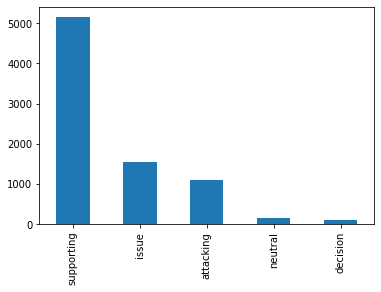

In [5]:

pd.value_counts(df['My_Labels']).plot.bar()

In [6]:
### Intitially
##Step1 -We Will Create an ANN and solve this problem(ROC AUC) 
##Step2- We will use some Weights handling techniques to solve this imbalanced then we create
##The ANN

In [7]:
len(df.columns)

6

In [8]:
df.drop(['Profile_Name','Headings','Rating_Star','Muliti_Label'],axis=1,inplace=True)

In [9]:
X = df.iloc[:,:-1]   
y = df.iloc[:,1] 

In [10]:
X.head(10)

,Base_Reviews
0,Downloaded this on a Kindle Fire 8 HD. No ind...
1,"It's free to download the app, but if you want..."
2,I download this app to my Kindle Fire HD. I tr...
3,Dirty trickster! It found my printer and print...
4,Love this for my kindle print needs
5,"The app installed easy, it recognized the prin..."
6,Makes my Amazon Fire print wirelessly and simply
7,I was able to set up y printer after having su...
8,It did work for one page with older Brother pr...
9,This is a pretty solid alternative to Cloud Pr...


In [11]:
y.head(10)

0      decision
1      decision
2         issue
3         issue
4    supporting
5      decision
6    supporting
7    supporting
8      decision
9    supporting
Name: My_Labels, dtype: object

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
y_train.value_counts()

supporting    3618
issue         1052
attacking      765
neutral         90
decision        76
Name: My_Labels, dtype: int64

In [19]:
##Step1
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [20]:
print(len(X.columns))
n_inputs=1

1


In [22]:
model = Sequential()
model.add(Dense(50, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X_train,y_train,epochs=10)

ValueError: could not convert string to float: 'Best app ever'